<a href="https://colab.research.google.com/github/TurkuNLP/register-DeepL/blob/main/register_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running this notebook put the file in the directory.

In [1]:
!wget -nc https://github.com/TurkuNLP/register-DeepL/blob/main/AfterDeepL/es_FINAL.tsv.gz # the repo is private so this does not work lol

File ‘es_FINAL.tsv.gz’ already there; not retrieving.



In [2]:
!pip3 install -q transformers datasets

In [3]:
import transformers
import datasets
import gzip 
import random
import re
import json
import torch

from pprint import PrettyPrinter
import logging
pprint = PrettyPrinter(compact=True).pprint
logging.disable(logging.INFO)

In [4]:
file_name = "en_train.downsampled.tsv"
data=[]
with open(file_name) as f:
    for line in f:
        #line = line.decode()
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=2: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

pprint(data[0])

['NA OP',
 "On Tuesday night, Sarah Palin dropped by Bill O'Reilly 's show to discuss "
 'some recent comments by Laura Ingraham , as well as the approach the '
 'Romney/Ryan ticket should take in the home stretch of campaigning. Hammering '
 'home the argument that Mitt Romney needs to be more aggressive, Palin '
 'defined the election as a choice between "free stuff or freedom." Asked '
 "about Ingraham's remark that if the Republicans can't win this election, "
 'they should shut down the party, Palin, too, agreed that this is a election '
 "that should be working in Romney's favor. Rush Limbaugh similarly said the "
 "president's reelection would signal the end of the GOP. The issue, she said, "
 'is that the message is getting across to voters. "If you can\'t get your '
 'message through that filter of media, then we\'re in a world of hurt," she '
 'said. What Republicans are failing to do, she added, is explain that voters '
 'have a choice: "Free stuff or freedom. You cannot hav

In [5]:
random.seed(1234) # remember to shuffle since the data is now in en,fi,swe,fre order
random.shuffle(data) 

In [6]:
# get a list of all the unique labels in the data using set which does not allow duplicates

labels = [one[0] for one in data]

#this splits all of the labels into their own thing for multilabeling
split_labels= []
for labeled in labels:
  labeleds = labeled.split()
  for label in labeleds:
    split_labels.append(label)
print(split_labels[:10])

labelset = set(split_labels) #split_labels
unique_labels=list(labelset)

# or make a label list from the picture which includes all the possibilities ? there should be 55 different but our dataset only has 43 which will do for now at least
# format of the labels? base+sub together in the label list?

texts= [one[1] for one in data]
print(len(unique_labels)) 
print(unique_labels[:10])

['NA', 'IN', 'HI', 'LY', 'IP', 'ID', 'NA', 'IN', 'IP', 'NA']
8
['IP', 'IN', 'ID', 'OP', 'LY', 'HI', 'NA', 'SP']


In [7]:
# split the labels into a list in the data
for i in range(len(data)):
  labeledlist = data[i][0]
  lablist = labeledlist.split()
  data[i][0] = lablist

print(data[0][0])

labels = [one[0] for one in data]
print(labels[:10])

['NA', 'IN']
[['NA', 'IN'], ['HI'], ['LY'], ['IP'], ['ID'], ['NA', 'IN'], ['IP'], ['NA', 'OP'], ['IN', 'OP'], ['ID']]


In [8]:
# indexlist = []
# line = []
# for i in range(len(data)):
#   lab = data[i][0]
#   for j in range(len(lab)):
#     line.append(unique_labels.index(lab[j]))
#   indexlist.append(line)
#   line= []
# print(indexlist[0])


# then one-hot encode all the labels in the data?
# I guess I could use pandas for this, first change everything to pandas format and then encode the labels

import pandas as pd

df = pd.DataFrame({
    "text": texts,
    "labels": labels
})
print(df)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
yt = mlb.fit_transform(df.labels)
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

ytlist= []
for labs in yt:
  ytlist.append(labs)


df = pd.DataFrame({
    "text": texts,
    "labels": ytlist
})

                                                   text    labels
0     Top Handset Maker Confirms Backdoor in One of ...  [NA, IN]
1     Public speaking is something that most of us h...      [HI]
2     Out On The Streets Lyrics Twisted Sister I wal...      [LY]
3     What is it? The Diet Solution program was crea...      [IP]
4     Small wrapper around a pre-existing HTTP clien...      [ID]
...                                                 ...       ...
2783  Lyla & Bertie Went To The Cotswolds We have ju...      [ID]
2784  Search Revolution 2.0 Will Not Be Televised Wh...  [NA, OP]
2785  Setting up a new company is fun, and part of t...      [IN]
2786  Gadgets & Stuff Gil Scott-Heron "The Last Holi...  [NA, OP]
2787  The Bride Who Fell In Love With Her Husband ( ...      [IP]

[2788 rows x 2 columns]
[0 0 1 0 0 1 0 0]
[('IN', 'NA')]
['HI' 'ID' 'IN' 'IP' 'LY' 'NA' 'OP' 'SP']


In [9]:
#print(df)
dataset = datasets.Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 2788
})


In [10]:
# with open("translated-register-data.jsonl", "wt") as f:
#     for cols, labs in zip(data, yt):
#         item = {
#             "text": cols[1],
#             "labels": labs.tolist() #labs #unique_labels.index(cols[0]),
#              # change this to have the binary one-hot encoded list of the labels, or a list of the labels => anyway a list
#         }
#         print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

In [11]:
# Dataset_ready = ""
# for label in unique_labels:
#   label = "\"" + label + "\""
#   Dataset_ready = Dataset_ready + label +": datasets.Value(\"int64\"), "

# pprint(Dataset_ready)

# # this makes the dataset ready to receive encoded data

In [12]:
# file = "translated-register-data.jsonl"
# dataset = datasets.load_dataset(
#     'json',                             
#     data_files={"everything":file}, # I need the test set from Veronika? ask Filip and Veronika
#     split={
#         "train":"everything[:80%]",  
#         "validation":"everything[80%:90%]",   
#         "test":"everything[90%:]"    
#     }#,
#     # features=datasets.Features({
#     #     "text":datasets.Value("string")   # glad I found out that this works even without the features specifically mentioned, huggingface documentation mentioned they were optional
#     # })
# )

#         # "labels":datasets.Sequence(datasets.ClassLabel(names=unique_labels)}), #datasets.ClassLabel(names=unique_labels), 
#         # # change this somehow to take all labels into account??? => datasets.Sequence(feature={}) that should include all the label features I want to give

# dataset     

In [13]:
dataset = dataset.train_test_split(test_size=0.2)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2230
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 558
    })
})


In [14]:
print(dataset["train"][0])

{'text': 'Cookies on The Couple Connection: The couple connection uses cookies to ensure that we give you the best experience on our website. If you continue to use the couple connection, we will assume that you are happy to receive all cookies from this site. Having an affair but can\'t leave marriage I really need someone to put my life back on track, to turn me back into the mother and wife I once was... a year ago, all that matters to me was my family whom I took pride in and would do a lot for them without expecting anything in return. After all, love is unconditional and as a mother, its my job to love, care and protect them. I didn\'t even ask a lot from my husband nor did he expect a lot from me. We were just in a good marriage, hardly any arguments between us and we took pride in our parenting and are proud of our beautiful, bright children. It all started when a single dad at school confessed to me that he finds me attractive and admitted fancying me for a while. It all came 

In [15]:
model_name = "xlm-roberta-base" # we use the xlmr for tokenizing (large)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True, # do something else other than truncating? the texts now have max 1024 tokens
    )

dataset = dataset.map(tokenize)

  0%|          | 0/2230 [00:00<?, ?ex/s]

  0%|          | 0/558 [00:00<?, ?ex/s]

In [16]:
# cast label IDs to floats
#dataset.remove_columns("text")
dataset.reset_format()
print(dataset["train"].format)
dataset.set_format(type="pandas", columns=['labels', 'input_ids', 'attention_mask'])
print(dataset["train"].format)
#print(dataset["train"][0])
dataset.set_format(type="torch", columns=['labels', 'input_ids', 'attention_mask'])
print(dataset["train"].format)
dataset = dataset.map(lambda x : {"float_labels": x["labels"].to(torch.float32)}, remove_columns=["labels", "text"])
#dataset.remove_columns("labels")
print(dataset)
dataset = dataset.rename_column("float_labels", "labels")

{'type': None, 'format_kwargs': {}, 'columns': ['text', 'labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}
{'type': 'pandas', 'format_kwargs': {}, 'columns': ['labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}
{'type': 'torch', 'format_kwargs': {}, 'columns': ['labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}


  0%|          | 0/2230 [00:00<?, ?ex/s]

  0%|          | 0/558 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'float_labels'],
        num_rows: 2230
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'float_labels'],
        num_rows: 558
    })
})


In [17]:
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels), problem_type="multi_label_classification")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [18]:
# I should change these eventually to find the best hyperparameters

trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=1500
)


In [24]:
# accuracy = datasets.load_metric("accuracy")

# def compute_accuracy(outputs_and_labels):
#     outputs, labels = outputs_and_labels
#     predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
#     return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)


# # for the actual multilabel thing we need to use another metric
# #microF1
# from sklearn.metrics import precision_recall_fscore_support
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro') # switch from binary to micro for multilabel at least
#   #  acc = accuracy_score(labels, preds)
#     return {
#    #     'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }
import numpy as np
from transformers import EvalPrediction
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.1):  # the treshold has to be really low because the probabilities of the predictions are not great, could even do without any treshold then? or find one that works best between 0.1 and 0.5
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels) # why is the sigmoid applies? could do without it
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    #next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [20]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [21]:
class MultilabelTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), 
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2230
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 558
    })
})

In [25]:
trainer = MultilabelTrainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
100,0.402300,0.395420,0.373965,0.661165,0.000000
200,0.392300,0.366230,0.375635,0.667972,0.000000
300,0.356200,0.345445,0.428164,0.724372,0.000000
400,0.338200,0.335072,0.436842,0.730593,0.000000
500,0.329700,0.318773,0.451052,0.745837,0.000000
600,0.314200,0.304762,0.458123,0.753395,0.000000
700,0.304900,0.311140,0.461115,0.753445,0.000000
800,0.299100,0.297770,0.466300,0.759678,0.000000
900,0.277500,0.288323,0.483322,0.774190,0.001792
1000,0.276400,0.284560,0.497080,0.784654,0.017921


TrainOutput(global_step=1500, training_loss=0.3039908231099447, metrics={'train_runtime': 1712.2651, 'train_samples_per_second': 7.008, 'train_steps_per_second': 0.876, 'total_flos': 3154871502520320.0, 'train_loss': 0.3039908231099447, 'epoch': 5.38})

In [26]:
eval_results = trainer.evaluate(dataset["test"])

print(eval_results)

{'eval_loss': 0.2749837636947632, 'eval_f1': 0.5156130997715156, 'eval_roc_auc': 0.7966971736919958, 'eval_accuracy': 0.06451612903225806, 'eval_runtime': 20.026, 'eval_samples_per_second': 27.864, 'eval_steps_per_second': 0.899, 'epoch': 5.38}


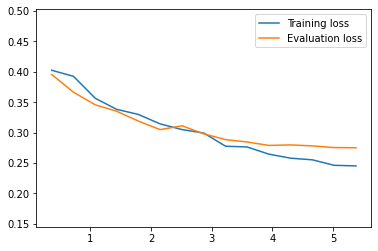

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

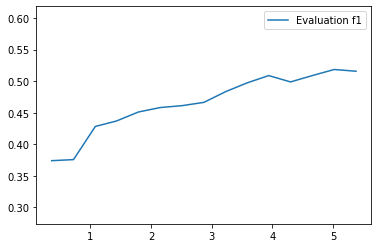

In [28]:
plot(training_logs.logs, ["eval_f1"], ["Evaluation f1"])

I think there are several reasons this does not work at all really:


2.   I am also truncating it to 512 and the original texts have 1024 tokens as agreed with filip to save space when translating texts -> another way to do this?
If I am truncating then it feels unnecessary to even have translated 1024 tokens but I guess more than 512 is needed although the beginning is apparently very telling when getting the register
3.   Accuracy is also not the best metric for this because there are so many combinations -> should do true multilabel and use another metric for that
4.   And for some registers (at least lyrical) the translations might not have been as good as hoped.

All in all, true multilabel is the only solution to this really and even then english data only having base labels might be an issue when the others have sublabels (this also depends on the target language test set and how the annotations are done)

